### Lecture des CSV (clients, data et sales) + affichage des 5 premières lignes des ventes 

In [ ]:
import pandas as pd

# Je charge les fichiers CSV dans des DataFrames pandas
clients = pd.read_csv("clients.csv")
data = pd.read_csv("data.csv")
sales = pd.read_csv("sales.csv")

# J'affiche la taille de chaque tableau (lignes, colonnes) pour vérifier que tout est bien chargé
print(clients.shape, data.shape, sales.shape)

# J'affiche les 5 premières lignes des ventes pour voir à quoi ressemblent les données
print(sales.head())



(1500, 2) (717, 10) (10000, 5)
   Id                 date                  products  client_id  is_discounted
0   0  2015-07-16 23:04:36                     [577]        770              0
1   1  2018-11-05 08:25:21  [443, 468, 16, 284, 374]       1046              0
2   2  2018-01-01 16:09:05   [388, 171, 591, 8, 133]        192              1
3   3  2016-11-01 10:21:23                       [4]         53              0
4   4  2016-08-15 20:09:51            [642, 357, 46]         81              1


### Nombre de client par pays

In [48]:
# Je compte le nombre de clients par pays :
# value_counts() compte combien de fois chaque pays apparaît dans la colonne "country"
clients_par_pays = clients["country"].value_counts()

# J'affiche le résultat (pays -> nombre de clients)
print(clients_par_pays)


country
France       627
Belgique     236
Allemagne    223
Italie       211
Espagne      203
Name: count, dtype: int64


### Top clients : ceux qui commandent le plus / dépensent le plus (avec les ventes)

In [49]:
# Je vérifie si la colonne "sale_id" existe dans sales
# Si elle n'existe pas, je crée un identifiant de commande en utilisant l'index
if "sale_id" not in sales.columns:
    sales = sales.reset_index().rename(columns={"index": "sale_id"})

# Je calcule le top 10 des clients qui passent le plus de commandes :
# je regroupe par client_id
# je compte le nombre de commandes uniques (nunique sur sale_id)
# je trie du plus grand au plus petit
# je garde les 10 premiers
top_commande = (sales.groupby("client_id")["sale_id"]
                .nunique()
                .sort_values(ascending=False)
                .head(10))

# Je transforme le résultat en DataFrame et je renomme la colonne en "nb_commandes"
# Puis je fais une jointure avec clients pour récupérer le pays (country)
top_commande = (top_commande.reset_index(name="nb_commandes")
                .merge(clients, left_on="client_id", right_on="Id", how="left"))

#Pour finir j'affiche le top 10 avec les infos client (dont le pays)
print(top_commande)


   client_id  nb_commandes    Id    country
0        952            16   952     France
1        469            16   469    Espagne
2       1116            16  1116     Italie
3        891            15   891     Italie
4       1441            14  1441  Allemagne
5       1366            14  1366     France
6         54            14    54     France
7       1435            14  1435   Belgique
8        526            14   526     France
9       1177            14  1177  Allemagne


### Nombre de commande par pays

In [50]:
# Jointure ventes / clients : ajoute les infos client (ex: country) à chaque vente via l'ID client
df_orders = sales.merge(clients, left_on="client_id", right_on="Id", how="left")

commandes_pays = df_orders.groupby("country").size()
print(commandes_pays)

country
Allemagne    1489
Belgique     1521
Espagne      1310
France       4218
Italie       1458
dtype: int64


### Total des ventes des commandes et total des produits vendus

In [51]:
# Je transforme la colonne "products" en liste de nombres
# Je récupère tous les nombres avec une regex (\d+)
# Puis je les convertis en int
sales["products_list"] = (
    sales["products"].astype(str)
    .str.findall(r"\d+")
    .apply(lambda L: list(map(int, L)))
)

# Je calcule le total des ventes :
# 1 ligne = 1 commande, donc je compte le nombre de lignes
total_ventes = len(sales)

# Je calcule le total des produits vendus :
# je compte le nombre d'éléments dans chaque liste, puis je fais la somme
total_produits = sales["products_list"].str.len().sum()

print("total des commandes : ", total_ventes)
print("total des produits lists : ", total_produits)


total des commandes :  10000
total des produits lists :  34760


### Nettoyage des prix avec la suppression du symbole ₹ et contrôle des valeurs manquantes en mettant 0 

**Nouveau tableau créé avec la suppresion des produits qui n'ont pas de prix actuel et de prix en réduction**

In [52]:
import numpy as np


# Je nettoie la colonne actual_price :
# - je transforme en texte
# - j'enlève le symbole ₹
# - je remplace les virgules par des points

data["actual_price"] = (data["actual_price"].astype(str)
                        .str.replace("₹", "", regex=False)
                        .str.replace(",", ".", regex=False))

#  Je fais la même chose pour discount_price
data["discount_price"] = (data["discount_price"].astype(str)
                          .str.replace("₹", "", regex=False)
                          .str.replace(",", ".", regex=False))



# Je convertis les colonnes en nombres :
# - je remplace les cellules vides par NaN
# - si ce n'est pas convertible, pandas met NaN
data["actual_price"] = pd.to_numeric(data["actual_price"].replace(r"^\s*$", np.nan, regex=True), errors="coerce")
data["discount_price"] = pd.to_numeric(data["discount_price"].replace(r"^\s*$", np.nan, regex=True), errors="coerce")
data = data.dropna(subset=["actual_price", "discount_price"], how="all")


# Affichages des 10 premières ligne
print(data[["actual_price", "discount_price"]].head(10))



   actual_price  discount_price
0         1.245         599.000
1       545.000         199.000
2       899.000         199.000
3         1.999         299.000
4         1.400         625.000
5         2.660           1.349
6        99.000          92.000
7         1.445         699.000
8         6.000           1.990
9         2.295           1.699


### Analyse des réductions avec les prix normal vs prix remisé

In [70]:

# Je repère les produits en réduction :
# C'estt-à-dire que discount_price doit être > 0
# c'est-à-dire que discount_price doit être inférieur au prix normal (actual_price)
data["is_discount"] = (data["discount_price"] > 0) & (data["discount_price"] < data["actual_price"])

# Je calcule le montant de la réduction (prix normal - prix remisé)
data["discount_amount"] = data["actual_price"] - data["discount_price"]

# Je calcule le pourcentage de réduction
# (montant réduction / prix normal) * 100
data["discount_percent"] = (data["discount_amount"] / data["actual_price"]) * 100

# J'affiche un aperçu des produits en réduction (10 premières lignes)
print(data.loc[data["is_discount"],
               ["actual_price", "discount_price", "discount_amount", "discount_percent"]].head(10))

# Je compte combien de produits sont en réduction (True = 1, False = 0)
print("Nb produits en réduction : ", data["is_discount"].sum())

# Je calcule la réduction moyenne (%) uniquement sur les produits en réduction
print("Réduction moyenne : ", data.loc[data["is_discount"], "discount_percent"].mean())


    actual_price  discount_price  discount_amount  discount_percent
1        545.000         199.000          346.000         63.486239
2        899.000         199.000          700.000         77.864294
5          2.660           1.349            1.311         49.285714
6         99.000          92.000            7.000          7.070707
8          6.000           1.990            4.010         66.833333
9          2.295           1.699            0.596         25.969499
10         3.500           1.329            2.171         62.028571
11         9.050           5.799            3.251         35.922652
12         3.210           2.099            1.111         34.610592
13       990.000         549.000          441.000         44.545455
Nb produits en réduction :  568
Réduction moyenne :  34.67162858376767


### Calcule du nouveau prix en fonction de la promotion

In [69]:
# Je crée une nouvelle colonne "new_price" (le prix final)
# Si le produit est en réduction (is_discount = True), je prends discount_price
# Sinon, je prends actual_price
data["new_price"] = np.where(data["is_discount"], data["discount_price"], data["actual_price"])

# J'affiche un aperçu des colonnes pour vérifier le résultat sur les 10 premières lignes
print(data[["actual_price", "discount_price", "is_discount", "new_price"]].head(10))


   actual_price  discount_price  is_discount  new_price
0         1.245         599.000        False      1.245
1       545.000         199.000         True    199.000
2       899.000         199.000         True    199.000
3         1.999         299.000        False      1.999
4         1.400         625.000        False      1.400
5         2.660           1.349         True      1.349
6        99.000          92.000         True     92.000
7         1.445         699.000        False      1.445
8         6.000           1.990         True      1.990
9         2.295           1.699         True      1.699


### Achats par client avec produit, pays et prix payé

Dans `sales.csv`, une commande contient plusieurs produits dans la colonne `products_list`. Pour analyser correctement (CA, produits vendus, achats par client…), j’ai donc :

* **Joint** avec `clients.csv` pour ajouter le **pays** du client.
* **Joint** avec `data.csv` pour ajouter les **infos produit** (nom, prix normal, prix promo).
* **Calculé `price_paid`** : si la commande est en promo (`is_discount_sale = 1`), je prends `discount_price`, sinon `actual_price`.

### Résultat

* **`final_tableau.csv`**

C’est un nouveau tableau csv où chaque ligne correspond à un achat (client, pays, produit, prix payé)

In [73]:


# Je transforme chaque commande en plusieurs lignes : 1 ligne = 1 produit acheté
sales_lines = sales.explode("products_list").rename(columns={"products_list": "product_id"})
sales_lines["product_id"] = pd.to_numeric(sales_lines["product_id"], errors="coerce")


# Je récupère le nom de la colonne promo dans les ventes (ici "is_discount")
for c in ["is_discount"]:
    if c in sales_lines.columns:
        promo_col = c
        break

# Je renomme la colonne promo pour éviter les conflits après les jointures
sales_lines = sales_lines.rename(columns={promo_col: "is_discount_sale"})

# Je garde seulement les colonnes utiles des clients et je renomme la clé
clients_small = clients[["Id", "country"]].rename(columns={"Id": "client_pk"})
# Je garde seulement les colonnes utiles des produits et je renomme la clé
data_small = data[["Id", "name", "actual_price", "discount_price"]].rename(columns={"Id": "product_pk"})

# Je fais les jointures pour ajouter le pays et les infos produit à chaque achat
purchases = (sales_lines
    .merge(clients_small, left_on="client_id", right_on="client_pk", how="left")
    .merge(data_small, left_on="product_id", right_on="product_pk", how="left")
)

# Je calcule le prix payé : si la commande est en promo -> discount_price, sinon -> le prix normale (actual_price)
purchases["price_paid"] = np.where(
    purchases["is_discount_sale"].eq(1),
    purchases["discount_price"],
    purchases["actual_price"]
)

# Je sélectionne les colonnes finales que je veux garder
cols_final = ["sale_id"]
if "date" in purchases.columns:
    cols_final.append("date")

cols_final += ["client_id", "country", "product_id", "name",
               "is_discount_sale", "actual_price", "discount_price", "price_paid"]

final_table = purchases[cols_final]

# J'exporte mon tableau final en CSV
final_table.to_csv("final_tableau.csv", index=False)
print("Fichier créé final_tableau.csv")


Fichier créé final_tableau.csv


### Graph 1: Nombre de commande par pays

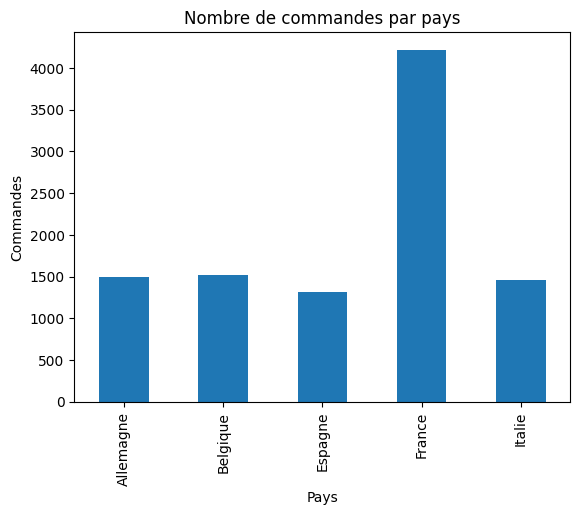

In [71]:
import matplotlib.pyplot as plt

# Je crée une nouvelle figure pour mon graphique
plt.figure()

# Je trace un graphique en barres à partir de "commandes_pays"
# commandes_pays doit contenir : index = pays, valeur = nombre de commandes
commandes_pays.plot(kind="bar")

# Je donne un titre au graphique
plt.title("Nombre de commandes par pays")

# Je nomme l'axe horizontal (les pays)
plt.xlabel("Pays")

# Je nomme l'axe vertical (le nombre de commandes)
plt.ylabel("Commandes")

# J'affiche le graphique
plt.show()



### Graph 2 : Top des produits les plus achetés

C:\Users\thoma\AppData\Local\Temp\ipykernel_14644\3871313179.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


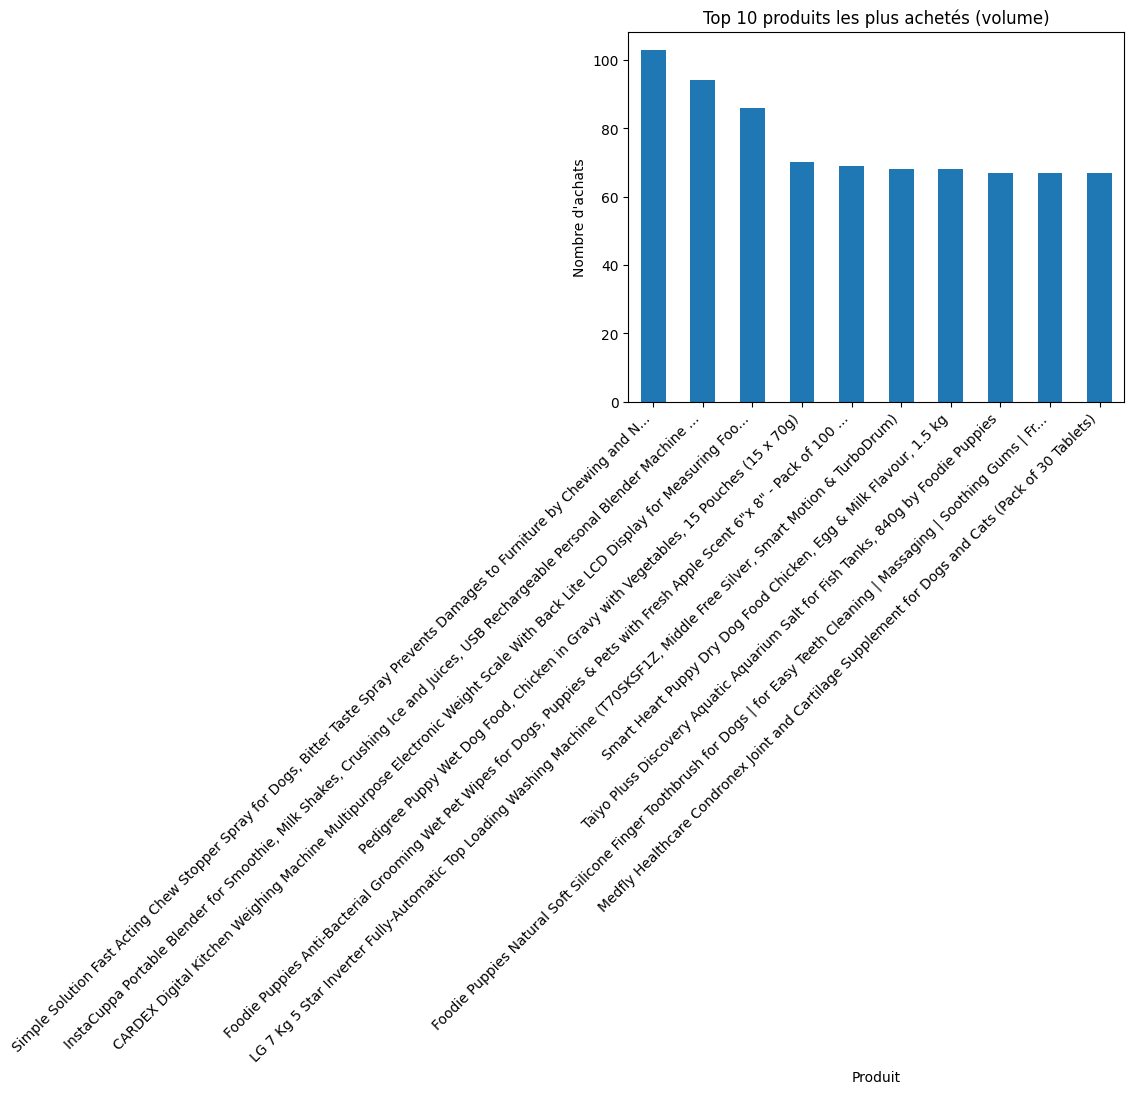

In [60]:
# Je compte combien de fois chaque produit a été acheté (en utilisant la colonne "name")

top_produits_volume = final_table["name"].value_counts().head(10)
plt.figure()

# Je trace un graphique en barres : chaque barre = un produit, hauteur = nombre d'achats
top_produits_volume.plot(kind="bar")


plt.title("Top 10 produits les plus achetés (volume)")
plt.xlabel("Produit")
plt.ylabel("Nombre d'achats")

# Je tourne les noms des produits pour que ça reste lisible
plt.xticks(rotation=45, ha="right")

# J'ajuste automatiquement l'affichage pour éviter que le texte soit coupé
plt.tight_layout()

plt.show()


### Graph 3 : Répartition des commandes par pays

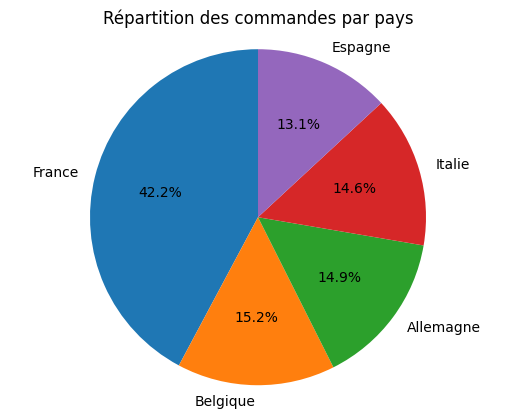

In [62]:
# Je calcule le nombre de commandes par pays
commandes_par_pays = (final_table.groupby("country")["sale_id"]
                      .nunique()
                      .sort_values(ascending=False))


plt.figure()

# Je trace un camembert (pie chart) :
# - chaque part représente un pays
# - autopct affiche le pourcentage sur le graphique
# - startangle=90 démarre le graphique à 90° pour une meilleure lecture
commandes_par_pays.plot(kind="pie", autopct="%1.1f%%", startangle=90)


plt.title("Répartition des commandes par pays")

# Je supprime le texte automatique de l'axe Y (inutile sur un camembert)
plt.ylabel("")

# Je force le camembert à être un cercle
plt.axis("equal")

plt.show()


### Graph 4 : Chiffre d'affaire par mois pour la France

C:\Users\thoma\AppData\Local\Temp\ipykernel_14644\4108420529.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_table["date"] = pd.to_datetime(final_table["date"], errors="coerce")


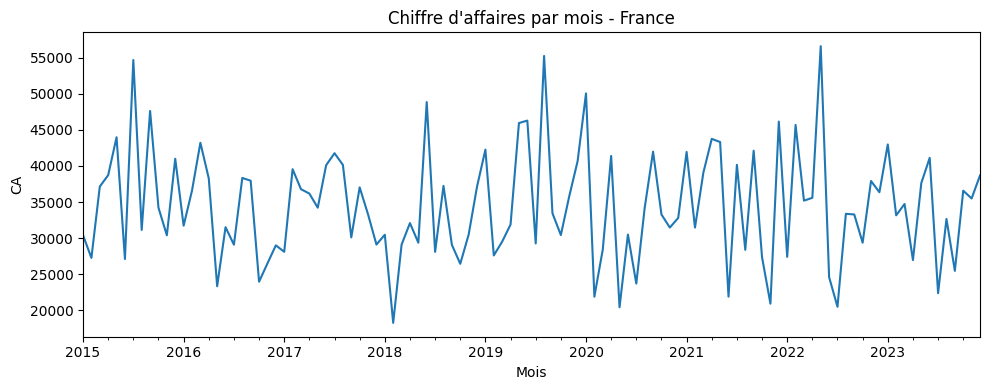

In [67]:


final_table["date"] = pd.to_datetime(final_table["date"], errors="coerce")

# Filtrage par France + CA par mois
ca_france = (final_table[final_table["country"] == "France"]
             .set_index("date")["price_paid"]
             .resample("MS").sum())

plt.figure(figsize=(10,4))
ca_france.plot()
plt.title("Chiffre d'affaires par mois - France")
plt.xlabel("Mois")
plt.ylabel("CA")
plt.tight_layout()
plt.show()


### Graph 5 : Evolution annuelle du chiffre d'affaire par pays

C:\Users\thoma\AppData\Local\Temp\ipykernel_14644\647888211.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_table["date"] = pd.to_datetime(final_table["date"], errors="coerce")


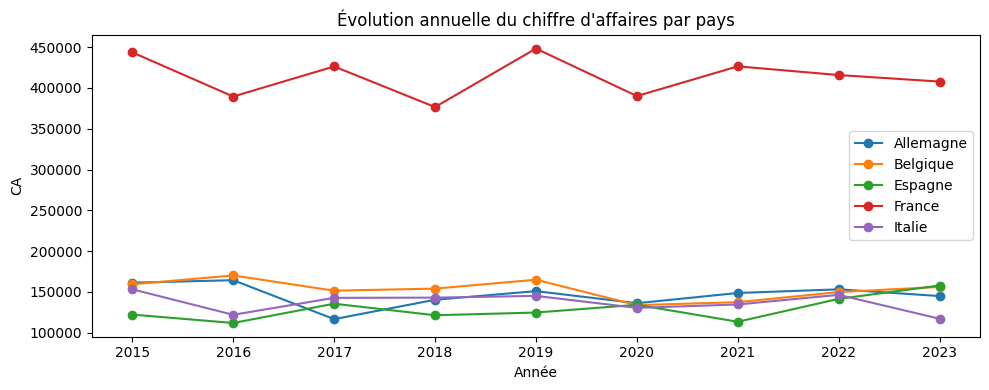

In [68]:


final_table["date"] = pd.to_datetime(final_table["date"], errors="coerce")

# Ici on calcule le CA par année et par pays
ca_annee_pays = (final_table
    .groupby(["country", pd.Grouper(key="date", freq="YS")])["price_paid"]
    .sum()
    .reset_index()
)

# Initialisation de la courbe par pays
plt.figure(figsize=(10,4))
for pays, g in ca_annee_pays.groupby("country"):
    plt.plot(g["date"].dt.year, g["price_paid"], marker="o", label=pays)

plt.title("Évolution annuelle du chiffre d'affaires par pays")
plt.xlabel("Année")
plt.ylabel("CA")
plt.legend()
plt.tight_layout()
plt.show()
